## SENTIMENT ANALYSIS USING BERT

### 1. Install and Import Dependencies

In [1]:
!pip3 install tensorflow==2.6
!pip3 install tensorflow-text==2.3
!pip3 install -q tf-models-official
!pip3 install "tensorflow>=1.15,<2.0"
!pip3 install --upgrade tensorflow-hub
!pip3 install torch==1.8.1+cu111 torchvision==0.9.1+cu111 torchaudio===0.8.1 -f https://download.pytorch.org/whl/torch_stable.html
!pip3 install transformers
!pip3 install torchvision

  Using cached tensorflow-2.6.0-cp38-cp38-manylinux2010_x86_64.whl (458.4 MB)
  Using cached opt_einsum-3.3.0-py3-none-any.whl (65 kB)
  Using cached astunparse-1.6.3-py2.py3-none-any.whl (12 kB)
  Using cached Keras_Preprocessing-1.1.2-py2.py3-none-any.whl (42 kB)
     |████████████████████████████████| 132 kB 8.6 MB/s eta 0:00:01
  Using cached h5py-3.1.0-cp38-cp38-manylinux1_x86_64.whl (4.4 MB)
Processing /home/rafael/.cache/pip/wheels/5f/fd/9e/b6cf5890494cb8ef0b5eaff72e5d55a70fb56316007d6dfe73/wrapt-1.12.1-cp38-cp38-linux_x86_64.whl
  Using cached gast-0.4.0-py3-none-any.whl (9.8 kB)
Processing /home/rafael/.cache/pip/wheels/a0/16/9c/5473df82468f958445479c59e784896fa24f4a5fc024b0f501/termcolor-1.1.0-py3-none-any.whl
  Using cached google_pasta-0.2.0-py3-none-any.whl (57 kB)
     |████████████████████████████████| 1.1 MB 45.3 MB/s eta 0:00:01
  Using cached keras-2.7.0-py2.py3-none-any.whl (1.3 MB)
  Using cached flatbuffers-1.12-py2.py3-none-any.whl (15 kB)
Processing /home/rafael/

  Using cached tensorflow_estimator-2.3.0-py2.py3-none-any.whl (459 kB)
  Using cached h5py-2.10.0-cp38-cp38-manylinux1_x86_64.whl (2.9 MB)
  Attempting uninstall: gast
    Found existing installation: gast 0.4.0
    Uninstalling gast-0.4.0:
      Successfully uninstalled gast-0.4.0
  Attempting uninstall: numpy
    Found existing installation: numpy 1.19.2
    Uninstalling numpy-1.19.2:
      Successfully uninstalled numpy-1.19.2
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.7.0
    Uninstalling tensorflow-estimator-2.7.0:
      Successfully uninstalled tensorflow-estimator-2.7.0
  Attempting uninstall: h5py
    Found existing installation: h5py 3.1.0
    Uninstalling h5py-3.1.0:
      Successfully uninstalled h5py-3.1.0
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.6.0
    Uninstalling tensorflow-2.6.0:
      Successfully uninstalled tensorflow-2.6.0
ERROR: Could not find a version that satisfie

  Using cached transformers-4.16.1-py3-none-any.whl (3.5 MB)
  Using cached sacremoses-0.0.47-py2.py3-none-any.whl (895 kB)
  Using cached huggingface_hub-0.4.0-py3-none-any.whl (67 kB)
  Using cached tokenizers-0.11.4-cp38-cp38-manylinux_2_12_x86_64.manylinux2010_x86_64.whl (6.8 MB)
ERROR: After October 2020 you may experience errors when installing or updating packages. This is because pip will change the way that it resolves dependency conflicts.

We recommend you use --use-feature=2020-resolver to test your packages with the new resolver before it becomes the default.

huggingface-hub 0.4.0 requires packaging>=20.9, but you'll have packaging 20.4 which is incompatible.


In [2]:
import tensorflow as tf
import tensorflow_hub as hub
import pandas as pd
import re
from transformers import BertTokenizer
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import numpy as np
import matplotlib.pyplot as plt
from transformers import BertTokenizer
import torch
import tensorflow_text as text
%matplotlib inline

### 2. LOADING DATA

In [15]:
dataset = pd.read_csv("data/all-data.csv", names=["label", "text"], header=0, encoding='latin-1')
print(dataset.head())
print(dataset['label'].value_counts())
label_encoder = preprocessing.LabelEncoder()
dataset['label'] = label_encoder.fit_transform(dataset['label'])

dataset['label'].value_counts()

      label                                               text
0   neutral  Technopolis plans to develop in stages an area...
1  negative  The international electronic industry company ...
2  positive  With the new production plant the company woul...
3  positive  According to the company 's updated strategy f...
4  positive  FINANCING OF ASPOCOMP 'S GROWTH Aspocomp is ag...
neutral     2878
positive    1363
negative     604
Name: label, dtype: int64


1    2878
2    1363
0     604
Name: label, dtype: int64

In [4]:
X = dataset['text']
label_encoder = preprocessing.LabelEncoder()
y = label_encoder.fit_transform(dataset['label'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2022)

### 3. BERT

#### BERT CLASSIFIER

In [5]:
bert_model = hub.KerasLayer('https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3')

In [6]:
def build_classifier_model():
  text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
  preprocessing_layer = hub.KerasLayer('https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3', name='preprocessing')
  encoder_inputs = preprocessing_layer(text_input)
  encoder = hub.KerasLayer('https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3', trainable=True, name='BERT_encoder')
  outputs = encoder(encoder_inputs)
  net = outputs['pooled_output']
  net = tf.keras.layers.Dropout(0.1)(net)
  net = tf.keras.layers.Dense(1, activation='softmax', name='classifier')(net) # Used for Multi-classification in the Logistics Regression model
  return tf.keras.Model(text_input, net)

In [7]:
bert_classifier_model = build_classifier_model()

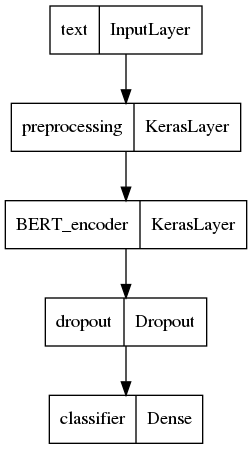

In [8]:
!pip3 install pydot
tf.keras.utils.plot_model(bert_classifier_model)

In [9]:
loss = tf.keras.losses.CategoricalCrossentropy()
metrics = tf.metrics.Accuracy()

#### BERT OPTIMIZER

In [10]:
bert_classifier_model.compile(optimizer='adam',
                         loss=loss,
                         metrics=metrics)

In [11]:
from sklearn.utils import class_weight 
class_weights = class_weight.compute_class_weight('balanced', np.unique(dataset['label']), dataset['label'])
class_weights = dict(enumerate(class_weights))

/home/rafael/anaconda3/envs/imageUnderstandingEnv/lib/python3.8/site-packages/sklearn/utils/validation.py:67: FutureWarning: Pass classes=[0 1 2], y=0       1
1       0
2       2
3       2
4       2
       ..
4840    0
4841    1
4842    0
4843    0
4844    0
Name: label, Length: 4845, dtype: int64 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


In [35]:
history = bert_classifier_model.fit(X_train,
                               y_train,
                               validation_split=0.2,
                               class_weight=class_weights,
                               epochs=5)

Epoch 1/5
97/97 [==============================] - 1317s 13s/step - loss: 0.0000e+00 - accuracy: 0.5942 - val_loss: 0.0000e+00 - val_accuracy: 0.5812
Epoch 2/5
97/97 [==============================] - 1295s 13s/step - loss: 0.0000e+00 - accuracy: 0.5942 - val_loss: 0.0000e+00 - val_accuracy: 0.5812
Epoch 3/5
97/97 [==============================] - 1172s 12s/step - loss: 0.0000e+00 - accuracy: 0.5942 - val_loss: 0.0000e+00 - val_accuracy: 0.5812
Epoch 4/5
97/97 [==============================] - 1184s 12s/step - loss: 0.0000e+00 - accuracy: 0.5942 - val_loss: 0.0000e+00 - val_accuracy: 0.5812
Epoch 5/5
97/97 [==============================] - 1313s 14s/step - loss: 0.0000e+00 - accuracy: 0.5942 - val_loss: 0.0000e+00 - val_accuracy: 0.5812


In [64]:
loss, accuracy = bert_classifier_model.evaluate(X_test, y_test)

print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')

31/31 [==============================] - 114s 4s/step - loss: 0.0000e+00 - accuracy: 0.6037
Loss: 0.0
Accuracy: 0.603715181350708


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


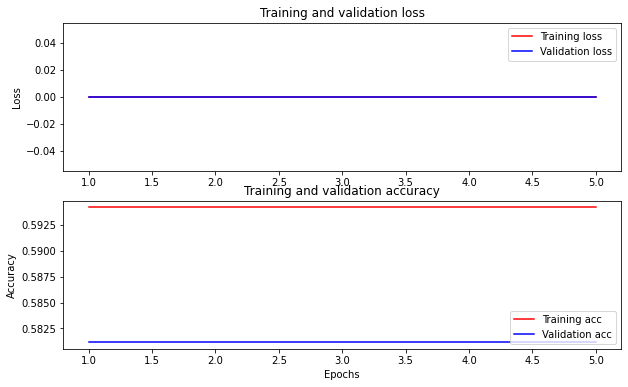

In [37]:
history_dict = history.history
print(history_dict.keys())

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10, 6))
fig.tight_layout()

plt.subplot(2, 1, 1)
# r is for "solid red line"
plt.plot(epochs, loss, 'r', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
# plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')